In [ ]:
# Create a dictionary 

In [148]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
from torch.utils.data import Dataset, DataLoader
import scipy

import matplotlib.animation as animation

from matplotlib.animation import FuncAnimation
import cv2 as cv

# from visualization import plot_heatmap_spatial

In [149]:
def segment_insole_data(insole_data):
    toe_region = insole_data[:, :13, :]  # Toe
    forefoot_region = insole_data[:, 13:31, :]  # Forefoot
    midfoot_region = insole_data[:, 32:42, :]  #  Midfoot
    heel_region = insole_data[:, 42:, :]  #  Heel
    return heel_region, midfoot_region, forefoot_region, toe_region

def butter_lowpass_filter(data, cutoff=8, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, 64, 16), dtype=data.dtype)
    for i in range(num_frames):
        frame = data[i].reshape(16, 64).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame

    return reshaped_data

def gait_segmentation(insole, h_th, t_th, ms_th):

    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_insole = (insole > 25).astype(int)

    p_heel_filtered = butter_lowpass_filter(p_heel, 8, 75)
    p_fore_filtered = butter_lowpass_filter(p_forefoot+p_toe, 8, 75)
    p_foot_filtered = butter_lowpass_filter(np.sum(insole, axis=(1, 2)), 8, 75)
    plt.figure()

    plt.plot(p_foot_filtered, label = "foot")
    plt.plot(p_fore_filtered, label = "fore")
    plt.plot(p_heel_filtered, label = "heel")
    plt.xlim(2020, 2090)
    plt.legend()

    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)

    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=10)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=10)
    ms_indices, _ = find_peaks(p_foot_filtered, height=ms_th, distance=30)
    
    return hc_indices, to_indices, ms_indices



def resample_data(data):
    n = data.shape[0]
    index = np.linspace(0, 100, n)
    target = np.linspace(0, 100, 100)
    resampled_data = np.zeros((100, 3))
    for i in range(3):
        interp_func = interp1d(index, data[:, i])
        resampled_data[:, i] = interp_func(target)

    return resampled_data


def get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds):
    """
    Get gait parameters from insole data
    """

    [h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] = thresholds

    gait = {'foot_trace_r': np.zeros(len(t_r)), 'foot_trace_l': np.zeros(len(t_l)),
            'dim': [int(np.sqrt(insole_r.shape[1]) * 2), int(np.sqrt(insole_r.shape[1]) / 2)],
            'cop_x_r': np.zeros(len(t_r)),
            'cop_y_r': np.zeros(len(t_r)),
            'cont_area_r': np.zeros(len(t_r)),
            'cop_x_l': np.zeros(len(t_l)),
            'cop_y_l': np.zeros(len(t_l)),
            'cont_area_l': np.zeros(len(t_l)),
            }
    insole_data = {'insole_r_flipped':[],
            'insole_l_flipped':[]}

    for i in range(len(t_r)):
        frame = insole_r[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        gait['foot_trace_r'][i] = np.mean(frame)
        insole_data['insole_r_flipped'].append(frame)
        x, y = np.where(frame > 0)

        # COP
        sum_frame_r = np.sum(frame[x, y])
        if sum_frame_r > 0:
            gait['cop_x_r'][i] = np.sum(x * frame[x, y]) / sum_frame_r
            gait['cop_y_r'][i] = np.sum(y * frame[x, y]) / sum_frame_r
        else:
            gait['cop_x_r'][i] = np.nan
            gait['cop_y_r'][i] = np.nan

        gait['cont_area_r'][i] = len(x)


    for i in range(len(t_l)):
        frame = insole_l[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        insole_data['insole_l_flipped'].append(frame)
        gait['foot_trace_l'][i] = np.mean(insole_l[i,:])


    # Gait events
    hc_indices, to_indices, ms_indices = gait_segmentation(insole_r, h_th_r, t_th_r, ms_th_r)
    strike_r = sorted(hc_indices)
    off_r = sorted(to_indices)
    ms_r = sorted(ms_indices)

    hc_indices, to_indices, ms_indices = gait_segmentation(insole_l, h_th_l, t_th_l, ms_th_l)
    strike_l = hc_indices
    off_l = to_indices
    ms_l = ms_indices

    # Isolate complete gait cycles
    gait['step_r'] = []
    gait['step_l'] = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        ms = [j for j in ms_r if start <= j <= end]
        if len(step_off) == 1:
            gait['step_r'].append({'strike': [start, end], 'ms': ms,'off': step_off})

    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        ms = [j for j in ms_l if start <= j <= end]

        if len(step_off) == 1:
            gait['step_l'].append({'strike': [start, end], 'ms': ms, 'off': step_off})

    # Cycle duration
    gait['cycle_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['swing_dur_l']= np.zeros((len(gait['step_l'])))
    gait['stance_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['cadence_l'] = np.zeros(len(gait['cycle_dur_l']))
    gait['cycle_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['swing_dur_r']= np.zeros((len(gait['step_r'])))
    gait['stance_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['cadence_r'] = np.zeros(len(gait['cycle_dur_r']))

    for i in range((len(gait['step_l']))):
        start, end = gait['step_l'][i]['strike']
        off = gait['step_l'][i]['off']
        gait['cycle_dur_l'][i] = t_l[end] - t_l[start]
        gait['stance_dur_l'][i] = t_l[off] - t_l[start]
    gait['swing_dur_l'] = gait['cycle_dur_l'] - gait['stance_dur_l']
    gait['stance_phase_l'] = gait['stance_dur_l']/gait['cycle_dur_l']
    gait['swing_phase_l'] = gait['swing_dur_l'] / gait['cycle_dur_l']
    gait['cadence_l'] = 60/gait['cycle_dur_l']

    for i in range((len(gait['step_r']))):
        start, end = gait['step_r'][i]['strike']
        off = gait['step_r'][i]['off']
        gait['cycle_dur_r'][i] = t_r[end] - t_r[start]
        gait['stance_dur_r'][i] = t_r[off] - t_r[start]
    gait['swing_dur_r'] = gait['cycle_dur_r'] - gait['stance_dur_r']
    gait['stance_phase_r'] = gait['stance_dur_r']/gait['cycle_dur_r']
    gait['swing_phase_r'] = gait['swing_dur_r'] / gait['cycle_dur_r']
    gait['cadence_r'] = 60/gait['cycle_dur_r']

    gait['swing_asym'] = np.abs((np.mean(gait['swing_phase_l']) - np.mean(gait['swing_phase_r']))) / (
            0.5 * (np.mean(gait['swing_phase_l']) + np.mean(gait['swing_phase_r'])))

    return gait, insole_data

In [150]:
insole_data_path = Path("data")
insole_data = sio.loadmat(insole_data_path / "gait_recording_080624_walk2.mat")

In [151]:
print(insole_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'insoleAll_l', 'insoleAll_r', 'jnt_angles_all_l', 'jnt_angles_all_r', 'jnt_pos_all_l', 'jnt_pos_all_r', 'tAll_l', 'tAll_r', 't_insole_l', 't_insole_r', 't_trackers'])


In [152]:
insole_l = insole_data['insoleAll_l']
insole_r = insole_data['insoleAll_r']
t_l = insole_data['t_insole_l']
t_r = insole_data['t_insole_r']
thresholds = [30, 30, 30,30, 10000,10000, 2, 2] #[h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] 

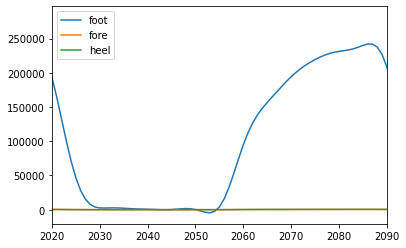

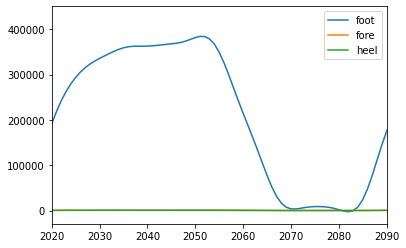

In [153]:
gait, insole_data = get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds)

In [154]:
# Extracting strike and off indices
# for step in gait['step_l']:
#     print(step)
#     prin
#     for start in step['strike']:
#         print(start)

strike_indices_l = [step['strike'][0] for step in gait['step_l']]
off_indices_l = [idx for step in gait['step_l'] for idx in step['off']]
ms_indices_l = [idx for step in gait['step_l'] for idx in step['ms']]

strike_indices_r = [step['strike'][0] for step in gait['step_r']]
off_indices_r = [idx for step in gait['step_r'] for idx in step['off']]
ms_indices_r = [idx for step in gait['step_r'] for idx in step['ms']]

Text(0.5, 0, 'Frame indices')

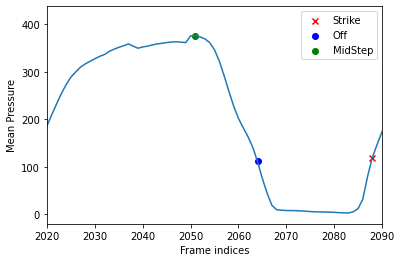

In [155]:
plt.plot(gait['foot_trace_l'])
# Plot 'strike' with 'x' markers
plt.scatter(strike_indices, [gait['foot_trace_l'][idx] for idx in strike_indices], 
            color='red', marker='x', label="Strike")

# Plot 'off' with 'o' markers
plt.scatter(off_indices, [gait['foot_trace_l'][idx] for idx in off_indices], 
            color='blue', marker='o', label="Off")

# Plot 'off' with 'o' markers
plt.scatter(ms_indices, [gait['foot_trace_l'][idx] for idx in ms_indices], 
            color='green', marker='o', label="MidStep")
plt.legend()
plt.xlim(2020, 2090)

plt.ylabel("Mean Pressure")
plt.xlabel("Frame indices")


In [156]:
def produce_slice(strike_indices, off_indices, ms_indices, insole_all):
    # Double support from heel strike to mid stance
    ds_startend = zip(strike_indices, ms_indices)
    ds_frames = np.vstack([np.stack(insole_all[s:e], axis=0) for s, e in ds_startend])

    # Single support from mid stance to toe off
    ss_startend = zip(ms_indices, off_indices)
    ss_frames = np.vstack([np.stack(insole_all[s:e], axis=0) for s, e in ss_startend])

    # Swing from toe off to next heel strike
    swing_startend = zip(off_indices[:-1], strike_indices[1:])
    swing_frames = np.vstack([np.stack(insole_all[s:e], axis=0) for s, e in swing_startend])

    return {"double": ds_frames, "single": ss_frames, "swing": swing_frames}
    

In [157]:
segments_l = produce_slice(strike_indices_l, off_indices_l, ms_indices_l, insole_data['insole_l_flipped'])

In [158]:
len(segments_l["double"]) + len(segments_l["single"]) + len(segments_l["swing"])

9041

In [159]:
len(insole_data['insole_l_flipped'])

9455

In [160]:
segments_r = produce_slice(strike_indices_r, off_indices_r, ms_indices_r, insole_data['insole_r_flipped'])

In [161]:
len(segments_r["double"]) + len(segments_r["single"]) + len(segments_r["swing"])

9095

In [162]:
len(insole_data['insole_r_flipped'])

9450

In [163]:
def compute_height_seg_coords(insole_spatial: np.ndarray, validate: bool = True, show_plot: bool = False) -> np.ndarray:
    NVALLEYS = 2
    NPEAKS = NVALLEYS + 1

    # mean across frames and columns
    colwise_mean = insole_spatial.mean(axis=(0, 2))

    # remove outliers i.e. a row of dead pixels
    # important the dead pixels don't create a large valley in the middle of the heel
    # which will blow out the toes
    medianed = scipy.signal.medfilt(colwise_mean, kernel_size=3)
    # smoothing filter
    # polyorders 2 and 3 have same effect because they share a center
    # window_length > 5 causes noticable drift in extrema locations
    smoothed = scipy.signal.savgol_filter(medianed, window_length=5, polyorder=2)

    # invert to get min instead of max
    valleys, valley_props = scipy.signal.find_peaks(-smoothed, prominence=0)

    valleys_mask = np.argsort(valley_props["prominences"])[-NVALLEYS:]

    peaks, peak_props = scipy.signal.find_peaks(smoothed, prominence=0)
    peaks_mask = np.argsort(peak_props["prominences"])[-NPEAKS:]

    if show_plot:
        plt.plot(colwise_mean, label="colwise mean")
        plt.plot(medianed, label="medianed")
        plt.plot(smoothed, label="smoothed")

        plt.plot(
            valleys[valleys_mask], smoothed[valleys[valleys_mask]], "o", label="valleys"
        )
        plt.vlines(
            x=valleys[valleys_mask],
            ymin=smoothed[valleys[valleys_mask]],
            ymax=valley_props["prominences"][valleys_mask]
            + smoothed[valleys[valleys_mask]],
            color="C3",
        )

        plt.plot(peaks[peaks_mask], smoothed[peaks[peaks_mask]], "x", label="peaks")
        plt.vlines(
            x=peaks[peaks_mask],
            ymin=smoothed[peaks[peaks_mask]] - peak_props["prominences"][peaks_mask],
            ymax=smoothed[peaks[peaks_mask]],
            color="C4",
        )

        plt.legend()
        plt.show()

    if validate:
        peak_valley_sorted = np.sort(
            np.hstack((peaks[peaks_mask], valleys[valleys_mask]))
        )

        # we want the ordering to be peak, valley, peak, valley, peak
        if not np.all(np.diff(np.isin(peak_valley_sorted, peaks[peaks_mask]))):
            raise Exception("validation failed")

    return valleys[valleys_mask]

def compute_width_seg_coords(insole_spatial: np.ndarray,height_valleys: np.ndarray,
    validate: bool = True,show_plot: bool = False,) -> np.ndarray:
    NVALLEYS = np.array([1, 1, 0])
    NPEAKS = NVALLEYS + 1
    TITLES = ["Toe", "Ball", "Heel"]

    # add 0 and len as bounds for window slide
    valleys_pad = np.r_[0, height_valleys, insole_spatial.shape[1]]

    width_valleys = []

    for i, window in enumerate(np.lib.stride_tricks.sliding_window_view(valleys_pad, 2)):
        # mean across frames and rows
        rowwise_mean = insole_spatial[:, window[0] : window[1], :].mean(axis=(0, 1))

        # remove outliers i.e. a row of dead pixels
        # important the dead pixels don't create a large valley in the middle of the heel
        # which will blow out the toes
        medianed = scipy.signal.medfilt(rowwise_mean, kernel_size=3)
        # smoothing filter
        # polyorders 2 and 3 have same effect because they share a center
        # window_length > 5 causes noticable drift in extrema locations
        smoothed = scipy.signal.savgol_filter(medianed, window_length=5, polyorder=2)

        # invert to get min instead of max
        valleys, valley_props = scipy.signal.find_peaks(-smoothed, prominence=0)

        valleys_mask = np.argsort(valley_props["prominences"])[-NVALLEYS[i] :]

        peaks, peak_props = scipy.signal.find_peaks(smoothed, prominence=0)
        peaks_mask = np.argsort(peak_props["prominences"])[-NPEAKS[i] :]

        if show_plot:
            plt.plot(rowwise_mean, label="rowwise mean")
            plt.plot(medianed, label="medianed")
            plt.plot(smoothed, label="smoothed")

            plt.plot(
                valleys[valleys_mask],
                smoothed[valleys[valleys_mask]],
                "o",
                label="valleys",
            )
            plt.vlines(
                x=valleys[valleys_mask],
                ymin=smoothed[valleys[valleys_mask]],
                ymax=valley_props["prominences"][valleys_mask]
                + smoothed[valleys[valleys_mask]],
                color="C3",
            )

            plt.plot(peaks[peaks_mask], smoothed[peaks[peaks_mask]], "x", label="peaks")
            plt.vlines(
                x=peaks[peaks_mask],
                ymin=smoothed[peaks[peaks_mask]]
                - peak_props["prominences"][peaks_mask],
                ymax=smoothed[peaks[peaks_mask]],
                color="C4",
            )

            plt.title(TITLES[i])

            plt.legend()
            plt.show()

        if validate:
            peak_valley_sorted = np.sort(
                np.hstack((peaks[peaks_mask], valleys[valleys_mask]))
            )

            # we want the ordering to be peak, valley, peak, etc.
            if not np.all(np.diff(np.isin(peak_valley_sorted, peaks[peaks_mask]))):
                raise Exception("validation failed")

        width_valleys.append(valleys)

    # don't keep empty heel valleys array
    return np.vstack(width_valleys[:-1])

In [ ]:
def plot_heatmap_static (insole_spatial_l: np.ndarray, insole_spatial_r: np.ndarray, save_anim: bool) -> None:
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

    img_l = ax_l.imshow(
        np.zeros((64, 16)),
        vmin=np.min(insole_spatial_l),
        vmax=np.max(insole_spatial_l),
        interpolation="nearest",
    )
    img_r = ax_r.imshow(
        np.zeros((64, 16)),
        vmin=np.min(insole_spatial_r),
        vmax=np.max(insole_spatial_r),
        interpolation="nearest",
    )

    ax_l.set_title("Left Heatmap")
    ax_r.set_title("Right Heatmap")
    plt.colorbar(img_l, ax=ax_l)
    plt.colorbar(img_r, ax=ax_r)

    hlines_l = [
        ax_l.axhline(height_valley_l, color="r", linestyle="--")
        for height_valley_l in height_valleys_l
    ]

    hlines_r = [
        ax_r.axhline(height_valley_r, color="r", linestyle="--")
        for height_valley_r in height_valleys_r
    ]

    vlines_l = [
        ax_l.vlines(
            width_valley_l,
            height_valleys_l[i - 1] if i > 0 else 0,
            height_valley_l,
            color="r",
            linestyle="--",
        )
        for i, (height_valley_l, width_valley_l) in enumerate(
            zip(height_valleys_l, width_valleys_l)
        )
    ]

    vlines_r = [
        ax_r.vlines(
            width_valley_r,
            height_valleys_r[i - 1] if i > 0 else 0,
            height_valley_r,
            color="r",
            linestyle="--",
        )
        for i, (height_valley_r, width_valley_r) in enumerate(
            zip(height_valleys_r, width_valleys_r)
        )
    ]
    
    return

In [123]:
def plot_heatmap_spatial(insole_spatial_l: np.ndarray, insole_spatial_r: np.ndarray, save_anim: bool) -> None:
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

    img_l = ax_l.imshow(
        np.zeros((64, 16)),
        vmin=np.min(insole_spatial_l),
        vmax=np.max(insole_spatial_l),
        interpolation="nearest",
    )
    img_r = ax_r.imshow(
        np.zeros((64, 16)),
        vmin=np.min(insole_spatial_r),
        vmax=np.max(insole_spatial_r),
        interpolation="nearest",
    )

    ax_l.set_title("Left Heatmap")
    ax_r.set_title("Right Heatmap")
    plt.colorbar(img_l, ax=ax_l)
    plt.colorbar(img_r, ax=ax_r)

    hlines_l = [
        ax_l.axhline(height_valley_l, color="r", linestyle="--")
        for height_valley_l in height_valleys_l
    ]

    hlines_r = [
        ax_r.axhline(height_valley_r, color="r", linestyle="--")
        for height_valley_r in height_valleys_r
    ]

    vlines_l = [
        ax_l.vlines(
            width_valley_l,
            height_valleys_l[i - 1] if i > 0 else 0,
            height_valley_l,
            color="r",
            linestyle="--",
        )
        for i, (height_valley_l, width_valley_l) in enumerate(
            zip(height_valleys_l, width_valleys_l)
        )
    ]

    vlines_r = [
        ax_r.vlines(
            width_valley_r,
            height_valleys_r[i - 1] if i > 0 else 0,
            height_valley_r,
            color="r",
            linestyle="--",
        )
        for i, (height_valley_r, width_valley_r) in enumerate(
            zip(height_valleys_r, width_valleys_r)
        )
    ]

    FRAME_OFFSET = 200

    def update(frame):
        frame += FRAME_OFFSET
        img_l.set_array(insole_spatial_l[frame])
        img_r.set_array(insole_spatial_r[frame])

        ax_l.set_ylabel(
            "Toe Off" if to_mask_l[frame] else "Heel Strike" if hc_mask_l[frame] else ""
        )
        ax_r.set_ylabel(
            "Toe Off" if to_mask_r[frame] else "Heel Strike" if hc_mask_r[frame] else ""
        )

        return (img_l, img_r, *hlines_l, *vlines_l, *hlines_r, *vlines_r, ax_l, ax_r)

    ani = FuncAnimation(
        fig,
        update,
        frames=range(
            FRAME_OFFSET,
            max(len(insole_spatial_l), len(insole_spatial_r)) - FRAME_OFFSET,
        ),
        # blit=True,
        repeat=True,
        interval=10,
    )
    plt.show()

    if save_anim:
        writervideo = animation.FFMpegWriter(fps=30)
        # ani.save("seg_walking.gif", writer=writervideo)


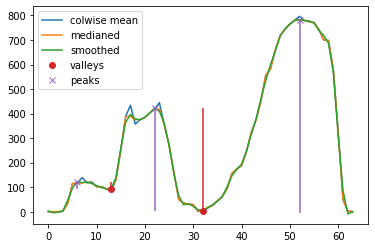

[13 32]


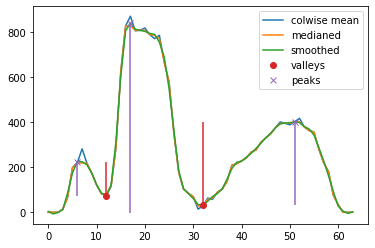

[12 32]


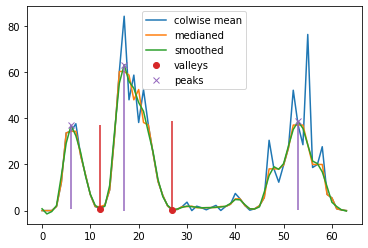

[12 27]


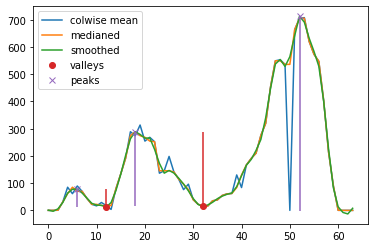

[12 32]


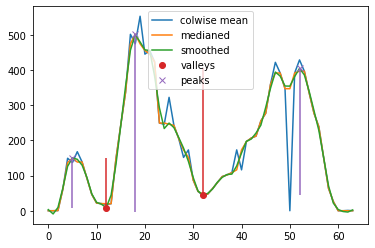

[12 32]


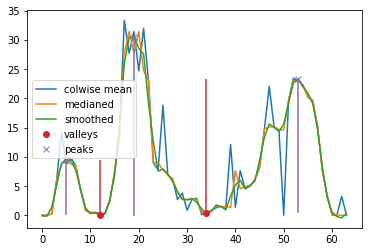

[12 34]


In [173]:
phases = ["double", "single", "swing"]
feet = ["l", "r"]
height_valleys_l_double = compute_height_seg_coords(segments_l["double"], validate=False, show_plot=True)
print(height_valleys_l_double)
height_valleys_l_single = compute_height_seg_coords(segments_l["single"], validate=False, show_plot=True)
print(height_valleys_l_single)
height_valleys_l_swing = compute_height_seg_coords(segments_l["swing"], validate=False, show_plot=True)
print(height_valleys_l_swing)
height_valleys_r_double = compute_height_seg_coords(segments_r["double"], validate=False, show_plot=True)
print(height_valleys_r_double)
height_valleys_r_single = compute_height_seg_coords(segments_r["single"], validate=False, show_plot=True)
print(height_valleys_r_single)
height_valleys_r_swing = compute_height_seg_coords(segments_r["swing"], validate=False, show_plot=True)
print(height_valleys_r_swing)

double l


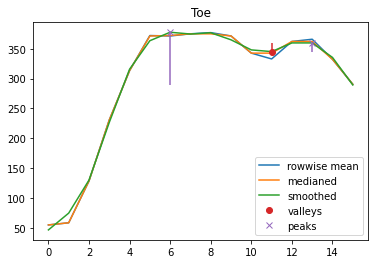

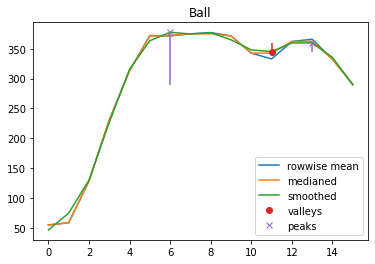

single l


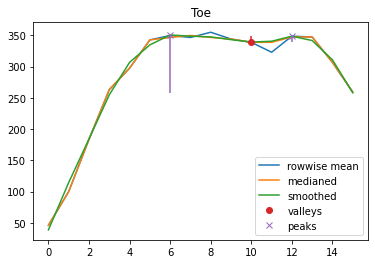

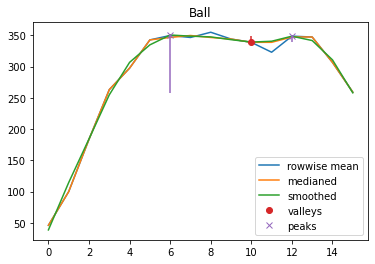

swing l


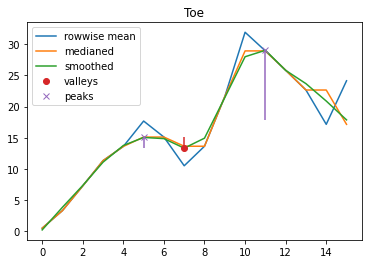

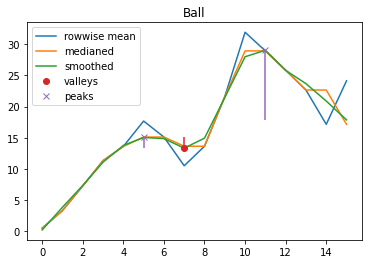

double r


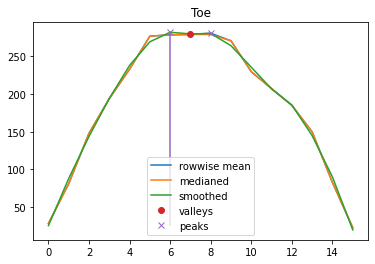

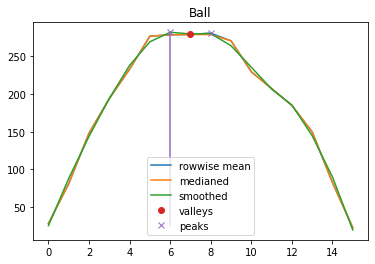

single r


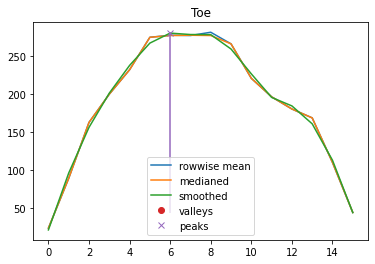

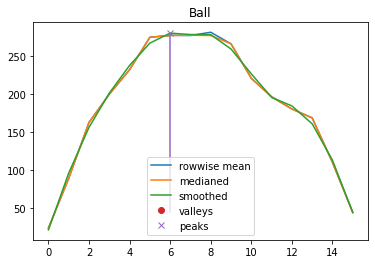

swing r


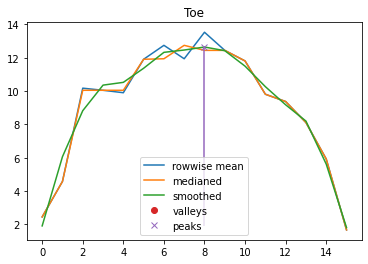

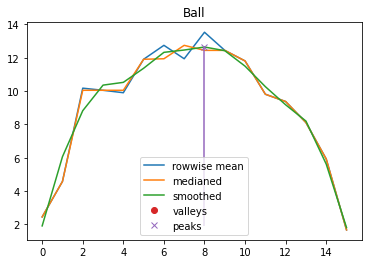

{'double': array([[ 7, 11]]), 'single': array([[10]]), 'swing': array([[7]])}
{'double': array([[7]]), 'single': array([], shape=(1, 0), dtype=int64), 'swing': array([], shape=(1, 0), dtype=int64)}


In [175]:
width_valleys_l = {}
width_valleys_r = {}
for foot in feet: 
    for phase in phases: 
        print(phase, foot)
        if foot == "l": 
            width_valleys_l[phase] = compute_width_seg_coords(segments_l[phase], exec("height_valleys_l_"+phase), validate=True, show_plot=True)
        else: 
            width_valleys_r[phase] = compute_width_seg_coords(segments_r[phase], exec("height_valleys_r_"+phase), validate=True, show_plot=True)

print(width_valleys_l)
print(width_valleys_r)


Text(0.5, 0.98, 'Swing Phase Average of Frames')

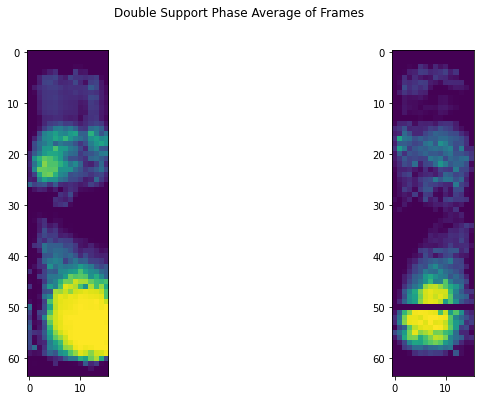

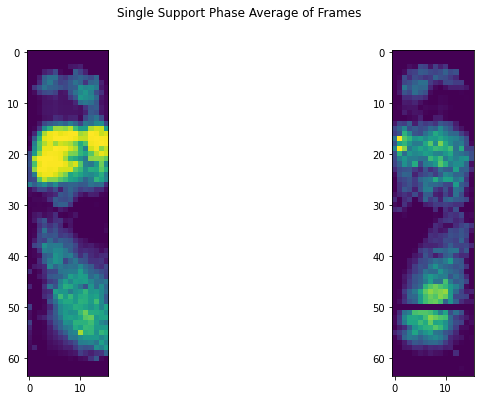

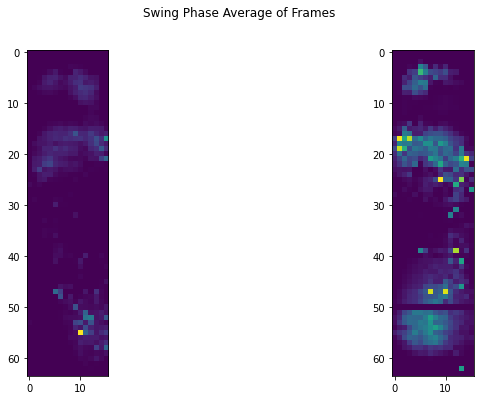

In [185]:
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

ax_l.imshow(np.mean(segments_l["double"],axis =0))
ax_r.imshow(np.fliplr(np.mean(segments_r["double"],axis =0)))
fig.suptitle("Double Support Phase Average of Frames")

fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

ax_l.imshow(np.mean(segments_l["single"],axis =0))
ax_r.imshow(np.fliplr(np.mean(segments_r["single"],axis =0)))

fig.suptitle("Single Support Phase Average of Frames")


fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

ax_l.imshow(np.mean(segments_l["swing"],axis =0))
ax_r.imshow(np.fliplr(np.mean(segments_r["swing"],axis =0)))
fig.suptitle("Swing Phase Average of Frames")



In [ ]:
plot_heatmap_spatial(insole_spatial_l, insole_spatial_r, save_anim=False)